In [1]:
# COMMENT OUT
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/IPython/extensions')

# Image Preprocessing

Here we will prepare the dataset by precomputing image representations using GoogLeNet CNN pretrained on the ImageNet dataset. In an ideal world, we would probably want to train our own CNN + RNN end-to-end, but given the small dataset (and to save ourselved some time since most of us don't have a GPU) we can use a pretrained network that has been trained on millions of natural images.

Although the CNN has been trained to classify 1000 natural image classes (e.g. 'car', 'dog'), we can still use it to extract useful vector representations from the deeper layers.

In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=cpu,floatX=float32"

In [2]:
import sklearn
import numpy as np
import lasagne
import skimage.transform
import random
# random.seed(123)
# np.random.seed(123)

from lasagne.utils import floatX
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
%matplotlib inline

import json
import pickle

Load the text report and MeSH caption data. We won't need it yet.

In [3]:
imagedir = 'jpeg_images/'
dataset = json.load(open('all_reports_train_test_split.json'))

Functions for building the GoogLeNet model with Lasagne are defined in googlenet.py:

In [4]:
import googlenet

We need to download parameter values for the pretrained network

In [ ]:
!wget -N https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/blvc_googlenet.pkl

Build the model and select layers we need - the features are taken from the final network layer, before the softmax nonlinearity.

In [15]:
cnn_layers = googlenet.build_model()
cnn_input_var = cnn_layers['input'].input_var
cnn_feature_layer = cnn_layers['pool5/7x7_s1']
cnn_output_layer = cnn_layers['prob']

get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

Load the pretrained weights into the network

In [16]:
model_param_values = pickle.load(open('blvc_googlenet.pkl'))['param values']
lasagne.layers.set_all_param_values(cnn_output_layer, model_param_values)

The images need some preprocessing before they can be fed to the CNN

In [17]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (224, w*224/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*224/w, 224), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

Let's verify that GoogLeNet and our preprocessing are functioning properly

(521, 512, 3)

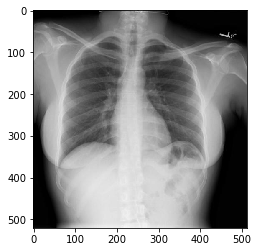

In [18]:
sample = random.choice(dataset)
im = plt.imread(imagedir + sample['imageid'] + '.jpg')
plt.imshow(im)
im.shape

In [19]:
rawim, cnn_im = prep_image(im)

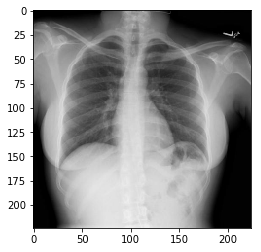

In [20]:
plt.imshow(rawim)

In [21]:
p = get_cnn_features(cnn_im)
CLASSES = pickle.load(open('blvc_googlenet.pkl'))['synset words']
print(CLASSES[p.argmax()])

bison


Iterate over the dataset and add a field 'cnn features' to each item. This will take quite a while.

In [22]:
def chunks(l, n):
    for i in xrange(0, len(l), n):
        yield l[i:i + n]

for chunk in chunks(dataset, 256):
    cnn_input = floatX(np.zeros((len(chunk), 3, 224, 224)))
    for i, exam in enumerate(chunk):
        try:
            im = plt.imread(imagedir + exam['imageid'] + '.jpg')
            _, cnn_input[i] = prep_image(im)
        except IOError:
            continue
    features = get_cnn_features(cnn_input)
    for i, exam in enumerate(chunk):
        exam['cnn features'] = features[i]

Save the final product

In [23]:
pickle.dump(dataset, open('chestx_with_cnn_features.pkl','w'), protocol=pickle.HIGHEST_PROTOCOL)